In [1572]:
""" Find suspension pulses for calibration
Critera:
- must start from ~0 travel
- must reach magnetic interest range within 0.5s

look for pulses of magnet above noise floor lasting <1s
look for zero travel?
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def print_err_stats(x, gt, prefix=""):
    error = x - gt
    rmse = np.mean(error ** 2) ** 0.5
    mae = np.mean(abs(error))
    me = np.mean(error)
    print(f"{prefix} RMSE: {rmse:.3f}, MAE: {mae:.3f}, ME: {me:.3f}")

In [1573]:
def fft_and_histogram(x, fs=100.0, detrend=True, window="hann",
                      hist_bins=80, hist_log=True, eps=1e-12):
    """
    x: 1D array of samples (sensor signal)
    fs: sample rate in Hz (100 by default)
    detrend: remove mean to kill DC offset
    window: "hann", "hamming", or None
    hist_bins: number of histogram bins
    hist_log: histogram of log10 magnitudes (usually nicer)
    eps: small number to avoid log(0)
    """
    x = np.asarray(x).astype(float)
    n = x.size

    if detrend:
        x = x - np.mean(x)

    if window is None:
        w = np.ones(n)
    elif window.lower() == "hann":
        w = np.hanning(n)
    elif window.lower() == "hamming":
        w = np.hamming(n)
    else:
        raise ValueError("window must be 'hann', 'hamming', or None")

    xw = x * w

    # One-sided real FFT
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(n, d=1.0/fs)

    # Amplitude spectrum (approx. amplitude-corrected for window + one-sided)
    # This gives a reasonable "amplitude per bin" style magnitude.
    # For noise-floor / comparisons, dB is often more informative anyway.
    w_gain = np.sum(w) / n
    mag = (2.0 / n) * np.abs(X) / max(w_gain, eps)
    mag[0] = mag[0] / 2.0  # don't double DC
    if n % 2 == 0:
        mag[-1] = mag[-1] / 2.0  # don't double Nyquist (only if it exists)

    # dB magnitude (optional, handy for plotting)
    mag_db = 20.0 * np.log10(mag + eps)

    # ---- Plot spectrum ----
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(f, mag)  # linear magnitude
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("FFT Magnitude Spectrum (one-sided)")
    plt.grid(True)

    #plt.figure()
    plt.subplot(1, 2, 2)
    plt.plot(f, mag_db)  # dB magnitude
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("FFT Magnitude Spectrum (dB)")
    plt.grid(True)

    # ---- Histogram of magnitudes ----
    # plt.figure()
    # if hist_log:
    #     vals = np.log10(mag + eps)
    #     plt.hist(vals, bins=hist_bins)
    #     plt.xlabel("log10(FFT magnitude)")
    #     plt.title("Histogram of FFT magnitudes (log10)")
    # else:
    #     plt.hist(mag, bins=hist_bins)
    #     plt.xlabel("FFT magnitude")
    #     plt.title("Histogram of FFT magnitudes")
    # plt.ylabel("Count")
    # plt.grid(True)

    plt.show()

    return f, mag, mag_db

# Example usage:
# x = np.loadtxt("sensor.csv")  # or however you load your data
# f, mag, mag_db = fft_and_histogram(x, fs=100.0)

['accel/lis1__t', 'accel/lis1__x', 'accel/lis2__t', 'accel/lis2__x', 'mag__t', 'mag__x', 'angle__t', 'angle__x', 'accel_filt/lis1__t', 'accel_filt/lis1__x', 'accel_filt/lis2__t', 'accel_filt/lis2__x', 'rotation_matrix', 'accel/lis2_in_lis1__t', 'accel/lis2_in_lis1__x', 'accel/relative__t', 'accel/relative__x', 'accel_filt/relative__t', 'accel_filt/relative__x', 'accel_trav_vec', 'mags_vs_means', 'accel/proj__t', 'accel/proj__x', 'accel_filt/proj__t', 'accel_filt/proj__x', 'angle/filt__t', 'angle/filt__x', 'travel__t', 'travel__x', 'mag_proj__t', 'mag_proj__x', 'travel/mag_polyfit__t', 'travel/mag_polyfit__x', 'travel_vs_mag', 'travel_vs_pred']
(79128, 1)


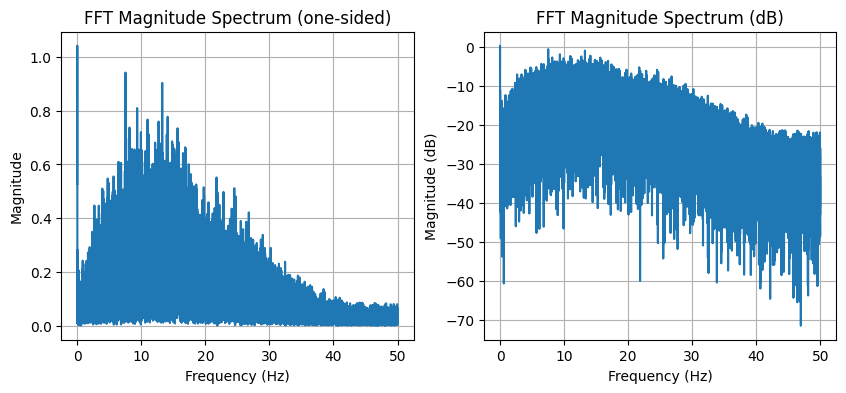

(array([0.00000000e+00, 1.26377515e-03, 2.52755030e-03, ...,
        4.99974724e+01, 4.99987362e+01, 5.00000000e+01], shape=(39565,)),
 array([0.5276654 , 1.04181203, 0.77834788, ..., 0.02889999, 0.01807222,
        0.00723339], shape=(39565,)),
 array([ -5.5528277 ,   0.35578738,  -2.17652502, ..., -30.78204713,
        -34.85976754, -42.81316216], shape=(39565,)))

In [1813]:
log_filename = "log022"
out_dir = f"backend/run_artifacts/{log_filename}/cache/"
ws_file = out_dir + "/all.npz"
ws = np.load(ws_file)
print([str(key) for key in ws.keys()])

t = ws["accel/proj__t"]
a_s2 = ws["accel/lis2_in_lis1__x"]
a_s1 = ws["accel/lis1__x"]
a_proj = ws["accel/proj__x"]
travel = ws["travel__x"][:, 0]
mag_proj = ws["mag_proj__x"]
a_s2_x = a_s2[:, 0]
a_s1_x = a_s1[:, 0]
print(a_proj.shape)
fft_and_histogram(a_s2_x, fs=100.0, detrend=True, window="hann",
                  hist_bins=80, hist_log=True, eps=1e-12)

In [1814]:
# Filter accel (HP + LP) 
lp_fc_hz = 20
fs = 100

sos_lp = butter(N=4, Wn=lp_fc_hz, btype="low", fs=fs, output="sos")
a_s1_x_lp = sosfiltfilt(sos_lp, a_s1_x)
a_s2_x_lp = sosfiltfilt(sos_lp, a_s2_x)
a_proj_lp = sosfiltfilt(sos_lp, a_proj[:, 0])

hp_fc_hz = 1
sos_hp = butter(N=4, Wn=hp_fc_hz, btype="high", fs=fs, output="sos")
a_s1_x_lhp = sosfiltfilt(sos_hp, a_s1_x_lp)
a_s2_x_lhp = sosfiltfilt(sos_hp, a_s2_x_lp)
a_proj_lhp = sosfiltfilt(sos_hp, a_proj_lp)

dt_s = np.diff(t, prepend=t[0]-0.01)
print(dt_s.shape)
print(travel.shape)
v = np.diff(travel, prepend=travel[0]) / dt_s

(79128,)
(79128,)


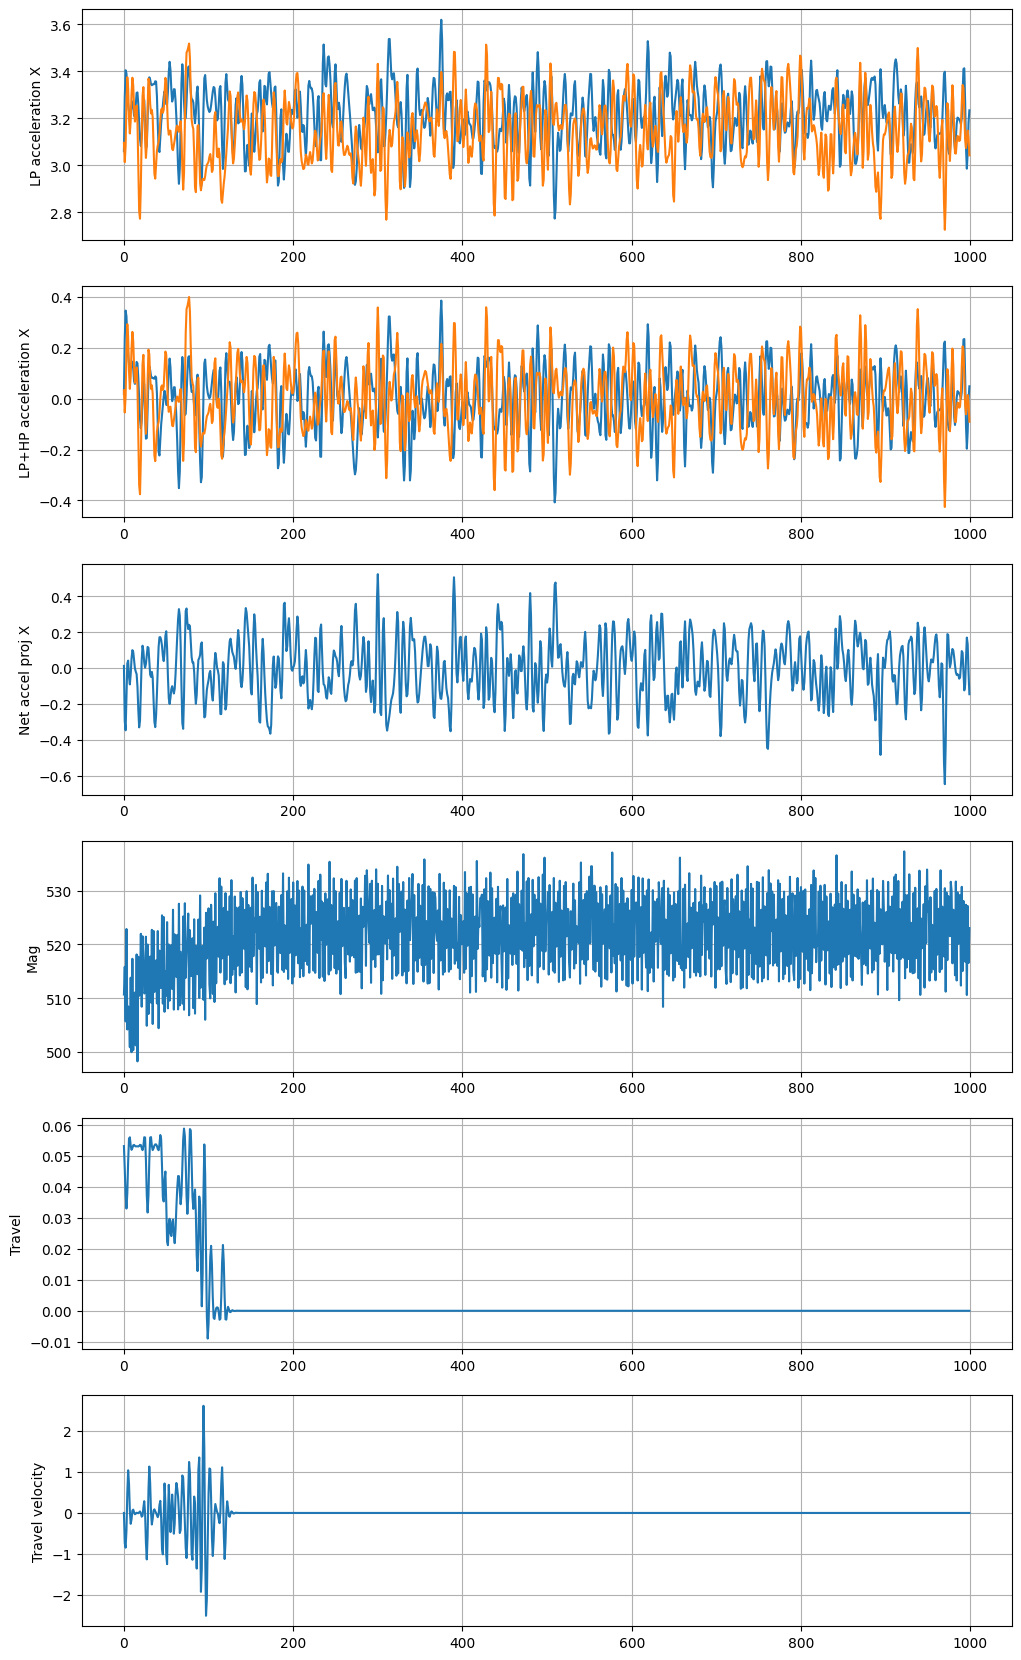

In [1815]:
# Plot stuff

#roi = slice(7900, 9000) #log022 cal pulses
#roi = slice(52000, 54000)
roi = slice(0, 1000)

plt.figure(figsize=(12, 21))
plt.subplot(6, 1, 1)
plt.ylabel("LP acceleration X")
plt.plot(a_s1_x_lp[roi])
plt.plot(a_s2_x_lp[roi])
plt.grid()
plt.subplot(6, 1, 2)
plt.ylabel("LP+HP acceleration X")
plt.plot(a_s1_x_lhp[roi])
plt.plot(a_s2_x_lhp[roi])
plt.grid()
plt.subplot(6, 1, 3)
plt.ylabel("Net accel proj X")
plt.plot(a_proj_lhp[roi])
plt.grid()
plt.subplot(6, 1, 4)
plt.ylabel("Mag")
plt.plot(mag_proj[roi])
plt.grid()
plt.subplot(6, 1, 5)
plt.ylabel("Travel")
plt.plot(travel[roi])
plt.grid()
plt.subplot(6, 1, 6)
plt.ylabel("Travel velocity")
plt.plot(v[roi])
plt.grid()

79128
All v 18.041248604243584 194.4629730334323
Still v 0.008857630123778888 3.5945810417161255
Still %: 28.384389849358005


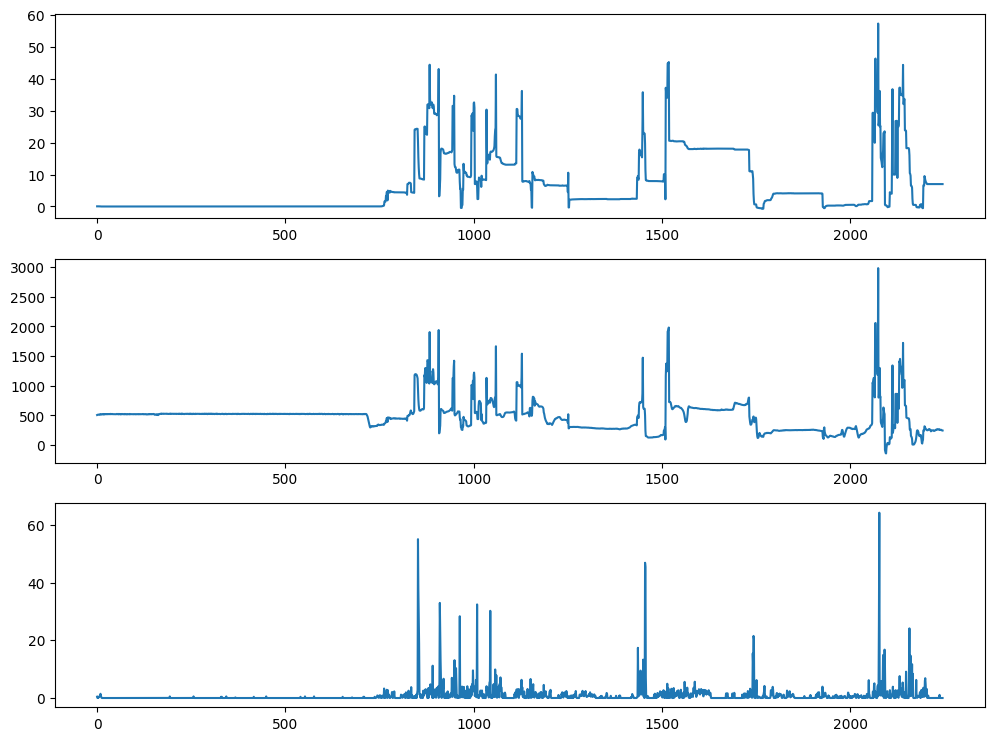

In [1816]:
# See how we can identify still sections
still_a_max = 0.5
still_len = 10

still_mags = []
still_as = []
still_travs = []
still_vs = []
for i in range(0, mag_proj.shape[0] - still_len, still_len):
    mag_chunk = mag_proj[i:i+still_len]
    a_chunk = a_proj_lhp[i:i+still_len]
    trav_chunk = travel[i:i+still_len]
    v_chunk = v[i:i+still_len]
    if max(abs(a_chunk)) < still_a_max:
        still_mags.append(mag_chunk)
        still_as.append(abs(a_chunk))
        still_travs.append(trav_chunk)
        still_vs.append(abs(v_chunk))

print(len(v))
print("All v", np.median(abs(v)), np.std(abs(v)))
print("Still v", np.median(still_vs), np.std(still_vs))
print("Still %:", len(still_vs) * still_len / len(v) * 100)
    
plt.figure(figsize=(12,9))
plt.subplot(3, 1, 1)
plt.plot([np.median(i) for i in still_travs])
plt.subplot(3, 1, 2)
plt.plot([np.median(i) for i in still_mags])
plt.subplot(3, 1, 3)
plt.plot([np.median(i) for i in still_vs])

In [1817]:
# Set up parameters for finding mag->travel training chunks
mag_baseline = np.mean(still_mags) + np.std(still_mags) #np.percentile(still_mags, 90)#
print("Mag baseline", mag_baseline)

# Data parameters
still_v_max = 1e9
bump_x_min = -1
still_mag_max = mag_baseline
bump_mag_min =  1000
still_a_max = 1000
bump_dx_min = 1

# Time parameters
still_len = 10
bump_len = 30
stride = 5
skips = 3 # number of following strides to skip if we find a good one, prevents repeats
chunk_len = still_len + bump_len

Mag baseline 732.2597423578977


Found bump at index 7885, still mean mag 376.7, bump max mag [2069.86039653]
Found bump at index 7930, still mean mag 412.0, bump max mag [3061.31876622]
Found bump at index 7970, still mean mag 414.6, bump max mag [1940.97478093]
Found bump at index 8015, still mean mag 460.8, bump max mag [3399.55120894]
Found bump at index 8065, still mean mag 447.4, bump max mag [2786.74247862]
Found bump at index 8110, still mean mag 389.8, bump max mag [4368.0739325]
Found bump at index 8150, still mean mag 390.9, bump max mag [3175.99054033]
Found bump at index 8190, still mean mag 478.4, bump max mag [4582.19728728]
Found bump at index 8240, still mean mag 464.5, bump max mag [3425.30277512]
Found bump at index 8280, still mean mag 465.7, bump max mag [4791.63994985]
Found bump at index 8330, still mean mag 460.2, bump max mag [3039.19448819]
Found bump at index 8370, still mean mag 458.2, bump max mag [4483.52156908]
Found bump at index 8865, still mean mag 447.0, bump max mag [2095.87433226]


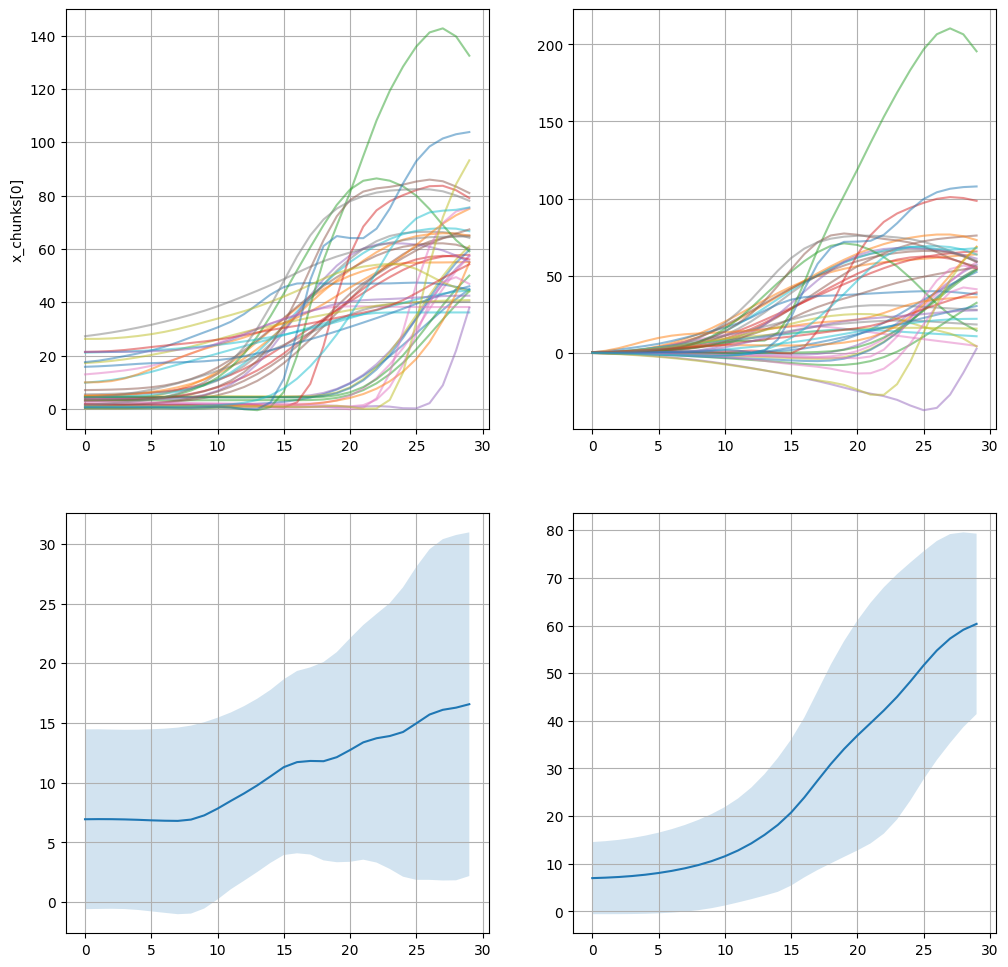

In [1818]:
a_mms = a_proj_lhp * 1000
still_slice = slice(0, still_len)
bump_slice = slice(still_len, still_len + bump_len)

slices = []
a_intint_chunks = []
i = 0
skip = 0
for i in range(0, travel.shape[0] - chunk_len, stride):
    if skip > 0:
        skip -= 1
        continue

    chunk_r = slice(i, i+chunk_len)
    chunk_l = slice(i+chunk_len, i, -1)
    chunks = [chunk_r, chunk_l]
    
    for chunk_i in chunks: 
        v_still = v[chunk_i][still_slice]
        mag_still = mag_proj[chunk_i][still_slice]
        a_still = a_mms[chunk_i][still_slice]

        a_bump = a_mms[chunk_i][bump_slice]
        dt_bump = dt_s[chunk_i][bump_slice]
        x_bump = travel[chunk_i][bump_slice]
        mag_bump = mag_proj[chunk_i][bump_slice]

        mag_still_mean = np.mean(mag_still)

        if max(abs(v_still)) > still_v_max:
            continue
        if (max(x_bump) - min(x_bump)) < bump_x_min:
            continue
        if np.mean(mag_still) > still_mag_max:
            continue
        if max(abs(a_still)) > still_a_max:
            continue
        if max(mag_bump) < mag_still_mean + bump_mag_min:
            continue
        print(f"Found bump at index {i}, still mean mag {mag_still_mean:.1f}, bump max mag {max(mag_bump)}")
        
        a_int = np.cumsum(a_bump * dt_bump)
        a_intint = np.cumsum(a_int * dt_bump)

        if a_intint[-1] < bump_dx_min:
            continue

        skip = skips

        a_intint_chunks.append(a_intint)
        slices.append(chunk_i)

x_chunks = [travel[chunk_i][bump_slice] for chunk_i in slices]
mag_chunks = [mag_proj[chunk_i][bump_slice][:, 0] for chunk_i in slices]
#x_chunks -= np.mean([x_chunk[0] for x_chunk in x_chunks], axis=0)  # remove mean to align better

abserrors = [abs(x_chunk - a_intint) for x_chunk, a_intint in zip(x_chunks, a_intint_chunks)]
abs_err_arr = np.asarray(abserrors)
print(abs_err_arr.shape)
error_avg = np.mean(abs_err_arr, axis=0)
error_std = np.std(abs_err_arr, axis=0)
travel_avg = np.mean([abs(chunk_i) for chunk_i in x_chunks], axis=0)
trav_std = np.std([abs(chunk_i) for chunk_i in x_chunks], axis=0)

mean_end_error = error_avg[-1]
mean_end_travel = travel_avg[-1]
print(f"Mean end error: {mean_end_error:.2f} mm, mean end travel: {mean_end_travel:.2f} mm")
print(f"Ratio of mean end error to mean end travel: {mean_end_error / mean_end_travel:.2%}")

print(slices)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.ylabel("x_chunks[0]")
for i in range(len(x_chunks)):
    plt.plot(x_chunks[i], alpha=0.5)
plt.grid()
plt.subplot(2, 2, 2)
for i in range(len(x_chunks)):
    plt.plot(a_intint_chunks[i], alpha=0.5)
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(error_avg)
plt.fill_between(range(len(error_avg)), error_avg - error_std, error_avg + error_std, alpha=0.2)
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(travel_avg)
plt.fill_between(range(len(travel_avg)), travel_avg - trav_std, travel_avg + trav_std, alpha=0.2)
plt.grid()

4139.002753716225 1000
(1230,) (398,)


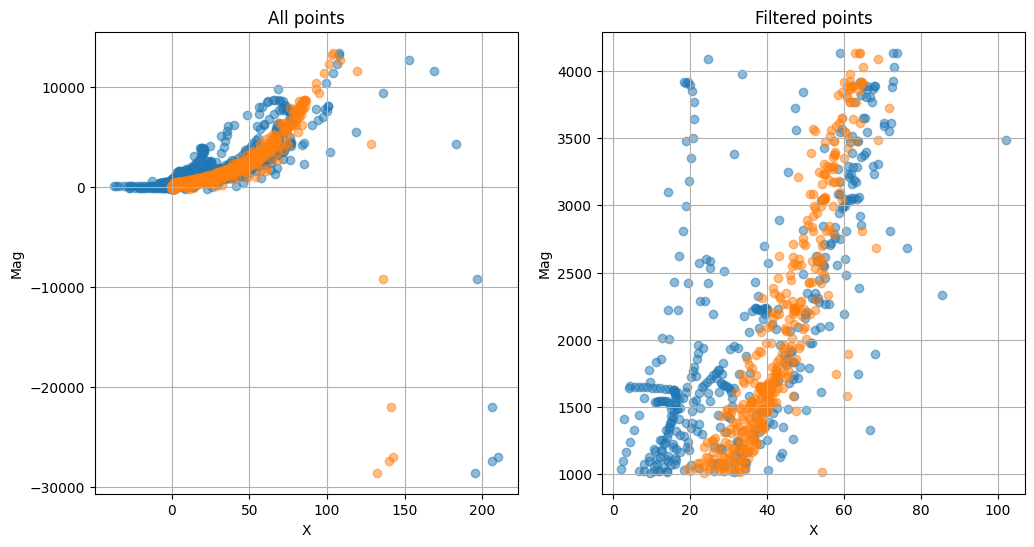

In [ ]:
# Filter accel/mag data from chunks and plot
mag_points = np.concatenate(mag_chunks)
pred_x_points = np.concatenate(a_intint_chunks)
x_points = np.concatenate(x_chunks)

mag_lower_thresh = 1000 # mag_baseline
mag_upper_thresh = np.percentile(mag_points[mag_points > mag_lower_thresh], 80)
print(mag_upper_thresh, mag_lower_thresh)

mag_mask = (mag_points > mag_lower_thresh) * (mag_points < mag_upper_thresh)
mag_points_filtered = mag_points[mag_mask]
pred_x_points_filtered = pred_x_points[mag_mask]
x_points_filtered = x_points[mag_mask]

chunks_filt = []
for (mag_chunk, a_intint) in zip(mag_chunks, a_intint_chunks):
    mask_i = (mag_chunk > mag_lower_thresh) * (mag_chunk < mag_upper_thresh)
    chunks_filt.append((mag_chunk[mask_i], a_intint[mask_i]))

print(mag_points.shape, mag_points_filtered.shape)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(pred_x_points, mag_points, alpha=0.5)
plt.scatter(x_points, mag_points, alpha=0.5)
plt.ylabel("Mag")
plt.xlabel("X")
plt.title("All points")
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(pred_x_points_filtered, mag_points_filtered, alpha=0.5)
plt.scatter(x_points_filtered, mag_points_filtered, alpha=0.5)
plt.ylabel("Mag")
plt.xlabel("X")
plt.title("Filtered points")
plt.grid()

Mag to travel fit RMSE: 37.026, MAE: 13.241, ME: -13.111
Mag to travel fit (filtered) RMSE: 9.941, MAE: 8.436, ME: -8.282
Mag to travel fit (filtered) to accel-int travel RMSE: 14.493, MAE: 11.682, ME: 0.000


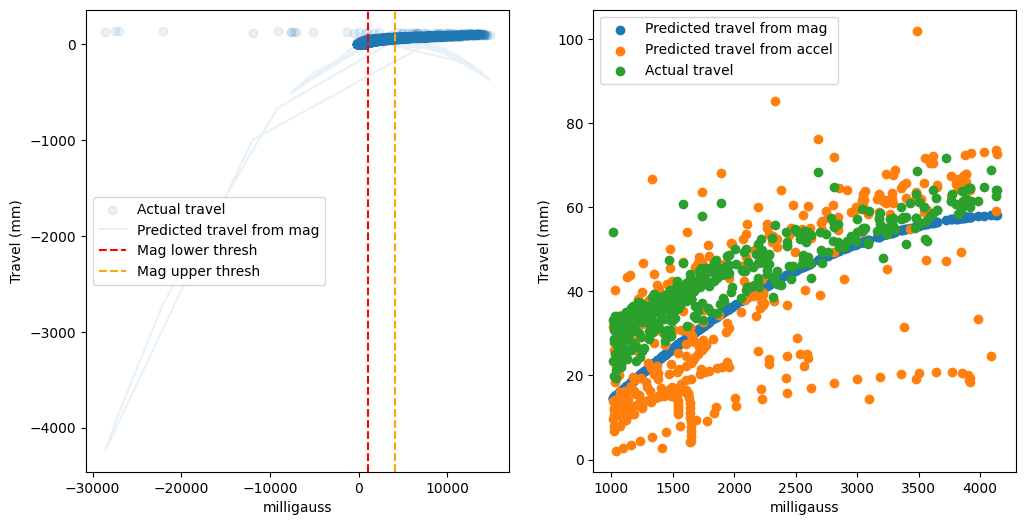

In [ ]:
fit_x_points = mag_points_filtered
fit_y_points = pred_x_points_filtered
#fit_x_points = mag_points
#fit_y_points = pred_x_points
#fit_x_points = np.asarray(med_filt_mag)
#fit_y_points = np.asarray(med_filt_x)
#fit_x_points = mag_proj
#fit_y_points = travel

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(fit_x_points.reshape(-1, 1))
model = LinearRegression()
model.fit(X_poly, fit_y_points)
mag_poly = poly.fit_transform(mag_points.reshape(-1, 1))
travel_filtered_preds = model.predict(mag_poly[mag_mask])
travel_preds = model.predict(mag_poly)

plt.figure(figsize=(12,6))

all_mag_poly = poly.fit_transform(mag_proj.reshape(-1, 1))
all_travel_preds = model.predict(all_mag_poly)

plt.subplot(1, 2, 1)
plt.scatter(mag_proj, travel, label="Actual travel", alpha=0.1)
plt.plot(mag_proj, all_travel_preds, alpha=0.1, label="Predicted travel from mag")
plt.axvline(mag_lower_thresh, color="red", linestyle="--", label="Mag lower thresh")
plt.axvline(mag_upper_thresh, color="orange", linestyle="--", label="Mag upper thresh")
plt.xlabel("milligauss")
plt.ylabel("Travel (mm)")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(mag_points_filtered, travel_filtered_preds, label="Predicted travel from mag")
plt.scatter(mag_points_filtered, pred_x_points_filtered, label="Predicted travel from accel")
plt.scatter(mag_points_filtered, x_points_filtered, label="Actual travel")
plt.xlabel("milligauss")
plt.ylabel("Travel (mm)")
plt.legend()

print_err_stats(all_travel_preds, travel, prefix="Mag to travel fit")
print_err_stats(travel_filtered_preds, x_points_filtered, prefix="Mag to travel fit (filtered)")
print_err_stats(travel_filtered_preds, pred_x_points_filtered, prefix="Mag to travel fit (filtered) to accel-int travel")

[(5, np.float64(183.05041643508426)), (19, np.float64(197.07554117799384)), (16, np.float64(270.40144850739927)), (28, np.float64(353.1364220742342)), (27, np.float64(694.0762045433987))]


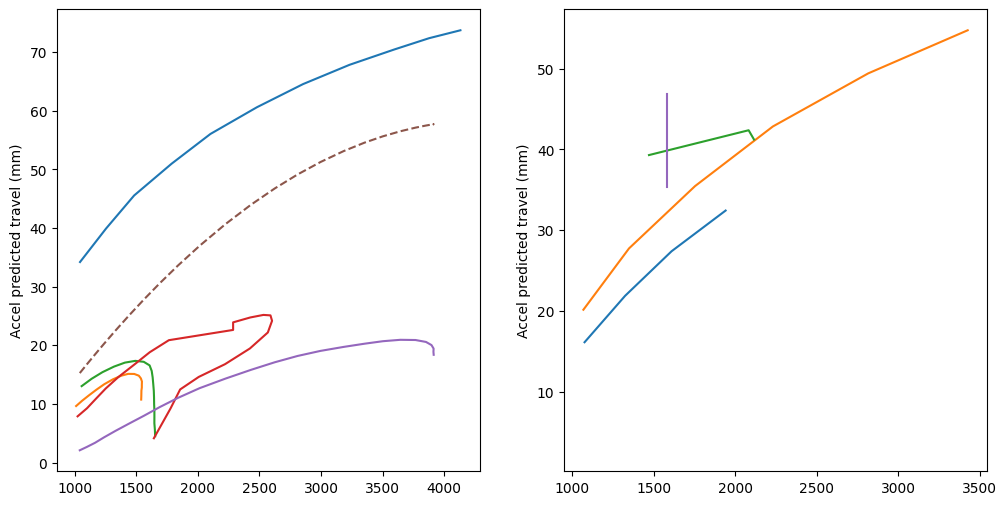

In [1829]:
# Find the chunks contributing the most to the error

pred_errors = []
y_preds = []
mags = []
a_ints = []
for (mag_chunk, a_int_chunk) in zip(mag_chunks, a_intint_chunks):
    mag_mask_i = (mag_chunk > mag_lower_thresh) * (mag_chunk < mag_upper_thresh)
    if np.where(mag_mask_i)[0].size > 0:
        x_poly = poly.fit_transform(mag_chunk[mag_mask_i].reshape(-1, 1))
        y_pred = model.predict(x_poly)
        pred_error = abs(a_int_chunk[mag_mask_i] - y_pred)
        mean_err = np.sum(pred_error)

        pred_errors.append(mean_err)
        y_preds.append(y_pred)
        mags.append(mag_chunk[mag_mask_i])
        a_ints.append(a_int_chunk[mag_mask_i])

errors_sorted = sorted(enumerate(pred_errors), key=lambda x: x[1])
print(errors_sorted[-5:])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.ylabel("Accel predicted travel (mm)")
for i in errors_sorted[-5:]:
    chunk_idx = i[0]
    plt.plot(mags[chunk_idx], a_ints[chunk_idx])
plt.plot(mags[chunk_idx], y_preds[chunk_idx], linestyle="--")
plt.subplot(1, 2, 2)
plt.ylabel("Accel predicted travel (mm)")
for i in errors_sorted[:5]:
    chunk_idx = i[0]
    plt.plot(mags[chunk_idx], a_ints[chunk_idx])
plt.plot(mags[chunk_idx], y_preds[chunk_idx], linestyle="--")


[35, 18, 19, 16, 24, 21, 28, 22, 27, 32]
[4, 15, 13, 6, 9, 12, 40, 7, 10, 36, 14, 8, 20, 0, 39, 3, 11, 1, 5, 2, 25, 17, 31, 34, 33, 30, 37, 23, 26, 29, 38]
Mean max pred travel 49.23050774638108
Mean std accel 7.8213493293618965
Mean max pred travel 58.518900140879715
Mean std accel 6.534759644232552
Worst mean end error: 37.72 mm


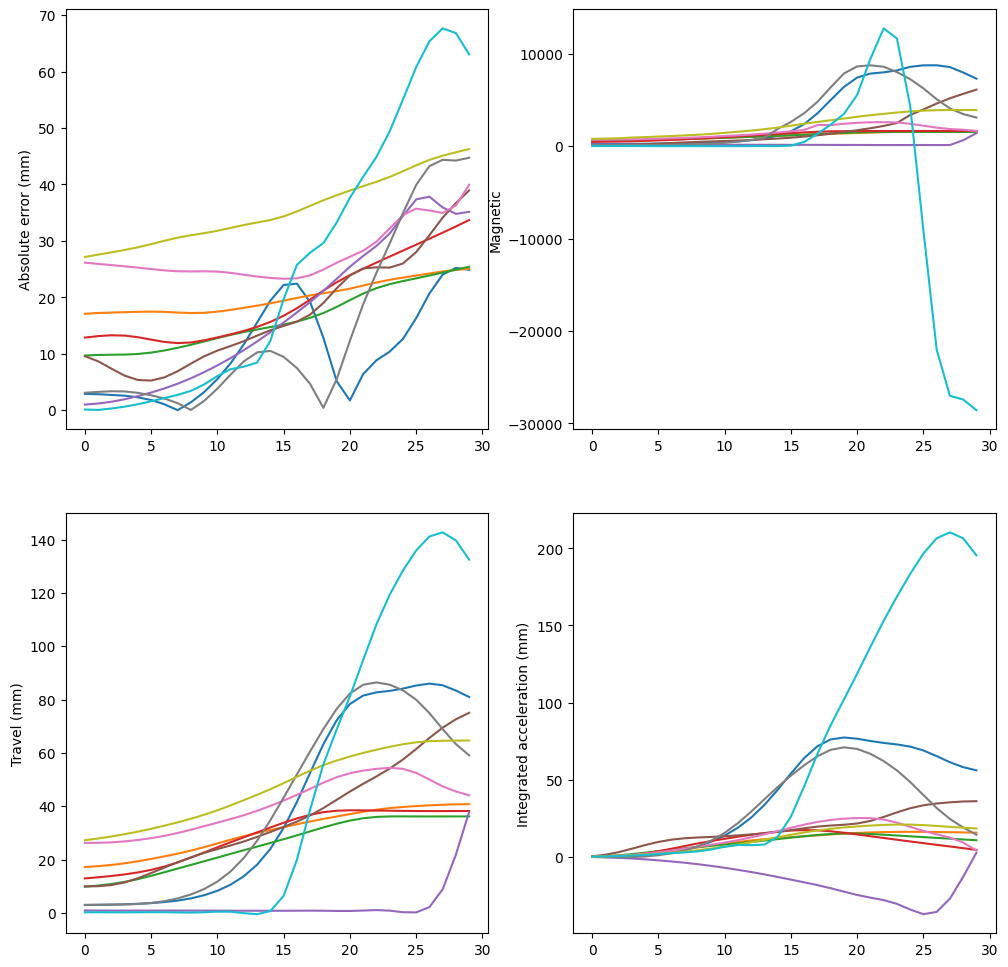

In [1830]:
# Find the worst chunks
errors_sorted = sorted(enumerate(slices), key=lambda x: abs_err_arr[x[0]][-1])

num_worst = len(errors_sorted) // 4

worst_slices = [x[1] for x in errors_sorted][-num_worst:]
worst_indices = [x[0] for x in errors_sorted][-num_worst:]
print(worst_indices)

ok_slices = [x[1] for x in errors_sorted][:-num_worst]
ok_indices = [x[0] for x in errors_sorted][:-num_worst:]
print(ok_indices)

for indices, name in [(worst_indices, "worst"), (ok_indices, "ok")]:
    print("Mean max pred travel", np.mean([max(a_intint_chunks[i]) for i in indices]))
    print("Mean std accel", np.mean([np.std(a_proj_lhp[slices[i]]) for i in indices]))

worst_mean_end_error = np.mean([abs_err_arr[i][-1] for i in worst_indices])
print(f"Worst mean end error: {worst_mean_end_error:.2f} mm")

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.ylabel("Absolute error (mm)")
for i in worst_indices:
    plt.plot(abserrors[i])
plt.subplot(2, 2, 2)
plt.ylabel("Magnetic")
for i in worst_indices:
    plt.plot(mag_chunks[i])
plt.subplot(2, 2, 3)
plt.ylabel("Travel (mm)")
for i in worst_indices:
    plt.plot(x_chunks[i])
plt.subplot(2, 2, 4)
plt.ylabel("Integrated acceleration (mm)")
for i in worst_indices:
    plt.plot(a_intint_chunks[i])

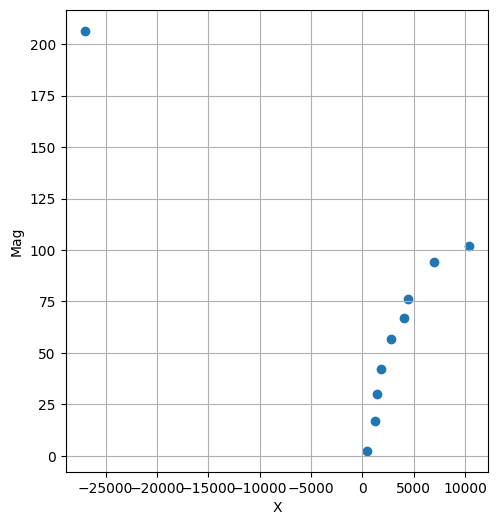

In [1831]:
# Try some point filtering methods 
num_bins = 20
min_bin_points = 3
x_pred_min, x_pred_max = min(pred_x_points), max(pred_x_points) + 1
bin_size = (x_pred_max - x_pred_min) / num_bins

med_filt_x = []
med_filt_mag = []
for i in range(num_bins):
    bin_min_x, bin_max_x = (bin_size * i), (bin_size * (i + 1))
    bin_mask = (pred_x_points >= bin_min_x) * (pred_x_points < bin_max_x)
    if np.where(bin_mask)[0].size >= min_bin_points:
        med_x = np.median(pred_x_points[bin_mask])
        med_mag = np.median(mag_points[bin_mask])
        med_filt_x.append(med_x)
        med_filt_mag.append(med_mag)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(med_filt_mag, med_filt_x)
plt.ylabel("Mag")
plt.xlabel("X")
plt.grid()